In [1]:
import torch, os
import wandb
import pandas as pd
from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.utils.data import Dataset

C:\Ana3\envs\wisnu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["WANDB_API_KEY"] = "REDACTED"

# set the wandb project where this run will be logged
os.environ["WANDB_PROJECT"]="training_pake_computer_binus"

# save your trained model checkpoint to wandb
os.environ["WANDB_LOG_MODEL"]="true"

# turn off watch to log faster
os.environ["WANDB_WATCH"]="true"

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
ROOT_DIR = 'D:\wisnu bert training' # If you have downloaded the data in local Machine

df_org= pd.read_csv(ROOT_DIR + '\data_700.csv')

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,Content,category
615013,you should be deeply embarrassed... by not ful...,hatespeech
75913,do not make me make you fall in love with a bi...,non-hatespeech
523130,trump america is anti immigrant sexual activit...,hatespeech
682117,you guys are clearly a pole smoker please get ...,hatespeech
395535,oh come along the only reason people like stri...,non-hatespeech


In [5]:
labels = df_org['category'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['hatespeech', 'non-hatespeech']

In [6]:
for key, value in enumerate(labels):
    print(value)

hatespeech
non-hatespeech


In [7]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [8]:
label2id

{'hatespeech': 0, 'non-hatespeech': 1}

In [9]:
id2label

{0: 'hatespeech', 1: 'non-hatespeech'}

In [10]:
df_org.head()

,Content,category
615013,you should be deeply embarrassed... by not ful...,hatespeech
75913,do not make me make you fall in love with a bi...,non-hatespeech
523130,trump america is anti immigrant sexual activit...,hatespeech
682117,you guys are clearly a pole smoker please get ...,hatespeech
395535,oh come along the only reason people like stri...,non-hatespeech


In [11]:
df_org["labels"]=df_org.category.map(lambda x: label2id[x.strip()])

In [12]:
df_org.head()

,Content,category,labels
615013,you should be deeply embarrassed... by not ful...,hatespeech,0
75913,do not make me make you fall in love with a bi...,non-hatespeech,1
523130,trump america is anti immigrant sexual activit...,hatespeech,0
682117,you guys are clearly a pole smoker please get ...,hatespeech,0
395535,oh come along the only reason people like stri...,non-hatespeech,1


<Axes: ylabel='count'>

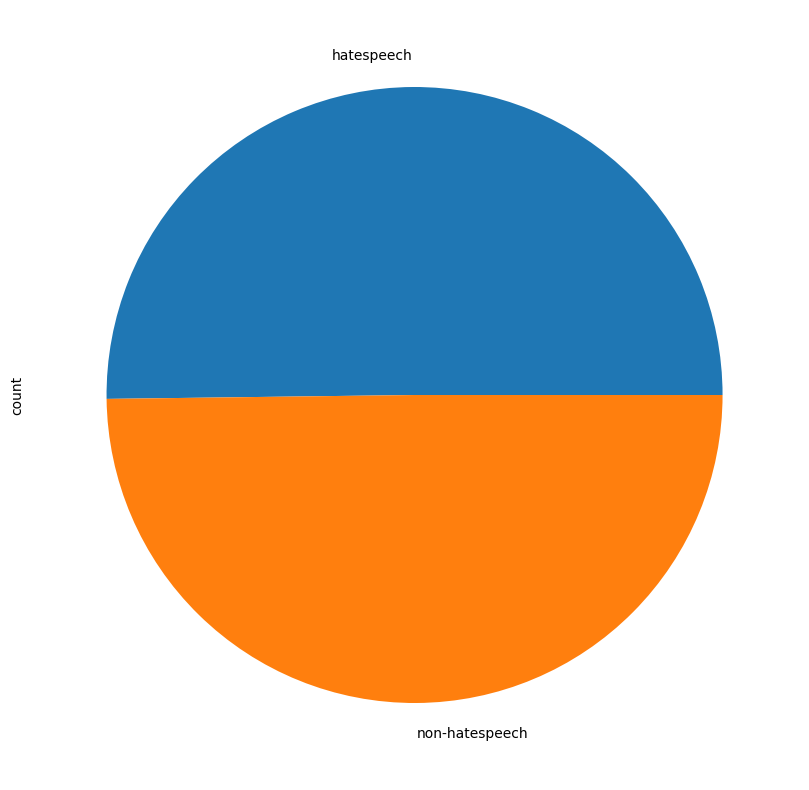

In [13]:
df_org.category.value_counts().plot(kind='pie', figsize=(10,10))

In [14]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512,do_lower_case=True)

In [15]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [16]:
SIZE = df_org.shape[0]

# 80% of the data for training
train_texts = list(df_org.Content[:8*SIZE//10])
train_labels = list(df_org.labels[:8*SIZE//10])

# 10% of the data for validation
val_texts = list(df_org.Content[8*SIZE//10:9*SIZE//10])
val_labels = list(df_org.labels[8*SIZE//10:9*SIZE//10])

# 10% of the data for testing
test_texts = list(df_org.Content[9*SIZE//10:])
test_labels = list(df_org.labels[9*SIZE//10:])


In [17]:
len(train_texts)


580895

In [18]:
len(train_texts), len(val_texts), len(test_texts)

(580895, 72612, 72612)

In [19]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [20]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


In [21]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [22]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [23]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model', 
    report_to="wandb",
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=5,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='epoch',  # Changed from 'steps' to 'epoch'
    # TensorBoard log directory                 
    logging_dir='./multi-class-logs',            
    evaluation_strategy="epoch",  # Changed from 'steps' to 'epoch'
    save_strategy="epoch",  # Changed from 'steps' to 'epoch'
    fp16=True,
    load_best_model_at_end=True,
    learning_rate=3e-5
   
)

In [24]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics
)

C:\Ana3\envs\wisnu_env\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [25]:
trainer.train()

wandb: Currently logged in as: wssnpgames (wisnu001binus). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.283100,0.238805,0.901490,0.901424,0.902631,0.901511
2,0.205900,0.239620,0.910153,0.910145,0.910278,0.910146
3,0.158900,0.287473,0.916047,0.916038,0.916212,0.916039
4,0.110000,0.330152,0.917438,0.917408,0.918006,0.917424
5,0.072000,0.399214,0.919958,0.919933,0.920450,0.919945


C:\Ana3\envs\wisnu_env\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


TrainOutput(global_step=181530, training_loss=0.16597036490826242, metrics={'train_runtime': 64523.9095, 'train_samples_per_second': 45.014, 'train_steps_per_second': 2.813, 'total_flos': 7.64199482516736e+17, 'train_loss': 0.16597036490826242, 'epoch': 5.0})

In [26]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.180620,0.927655,0.927610,0.928449,0.927565
val,0.238805,0.901490,0.901424,0.902631,0.901511
test,0.238367,0.901160,0.901048,0.902400,0.900968


In [27]:
model_path = "HateSpeech_BERT_base_720"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('HateSpeech_BERT_base_720\\tokenizer_config.json',
 'HateSpeech_BERT_base_720\\special_tokens_map.json',
 'HateSpeech_BERT_base_720\\vocab.txt',
 'HateSpeech_BERT_base_720\\added_tokens.json',
 'HateSpeech_BERT_base_720\\tokenizer.json')